# Parsing load test data

In [5]:
import json
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

def process_data(filename):
    with open(filename, 'r') as reader:
        text = reader.read().strip()
        text = "["+  text.replace("\n", ",") + "]"
        data = json.loads(text)

    scenario_data = {}

    for entry in data:
        try:
            scenario = entry["data"]["tags"]["scenario"]
        except:
            continue

        if scenario not in scenario_data:
            scenario_data[scenario] = {}

        
        if entry["metric"] not in scenario_data[scenario]:
            # first entry - create the list
            scenario_data[scenario][entry["metric"]] = [entry["data"]["value"]]
        else:
            # other entries - append to the lost
            scenario_data[scenario][entry["metric"]].append(entry["data"]["value"])

    cols = []
    frames = []

    for user_id, d in scenario_data.items():
        cols.append(user_id)
        frames.append(pd.DataFrame.from_dict(d))

    df = pd.concat(frames, keys=cols)
    return df

def print_success_rates(df):
    for scen in df.index.levels[0]:
        success = df.loc[scen]["checks"].sum()/df.loc[scen]["checks"].count()
        print(f"Success rate for {scen} is {success*100:.2f}%")

def boxplots(df):
    fig, ax = plt.subplots(figsize=(25,6))
    df.unstack(level=0)["iteration_duration"].boxplot(ax=ax, showfliers=False)
    plt.title("Boxplots for latency")
    plt.show()

def duration_vs_success(df, duration_in_seconds):
    for scen in df.index.levels[0]:
        data = fix_index(df.loc[scen], duration_in_seconds)
        fig, ax = plt.subplots(figsize=(25,3))
        ax2 = ax.twinx()
        ax.plot(data["iteration_duration"], color="blue")
        ax2.plot((1-data["checks"]).cumsum(), color="red")
        ax.set_ylabel("Iteration duration [ms]")
        ax2.set_ylabel("Cumulative number of failed checks")
        plt.title(f"Latency and number of failed checks for {scen}")
        plt.show()

def fix_index(data, duration_in_seconds):
    data.index = data.index * duration_in_seconds / data.index.max()
    return data

## Single instance analysis (`concurrency = 10`, `max-size = 1`)

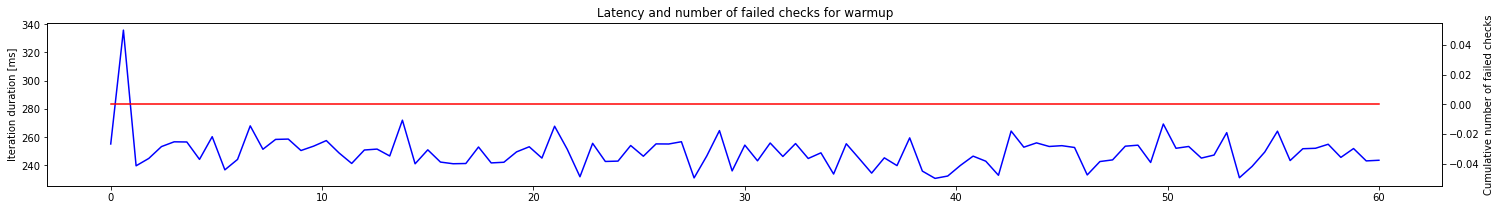

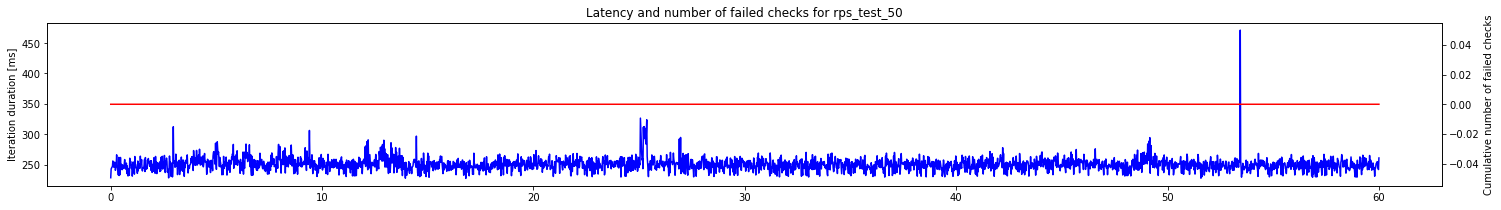

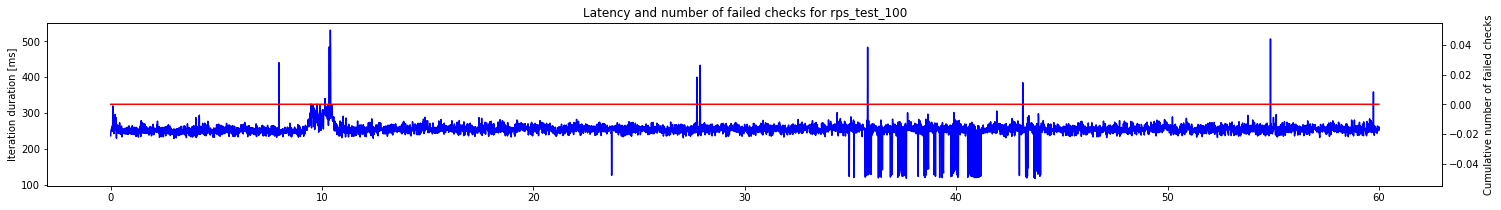

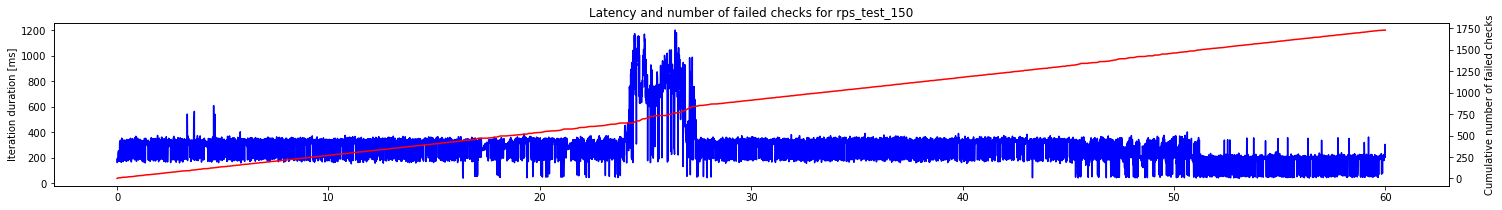

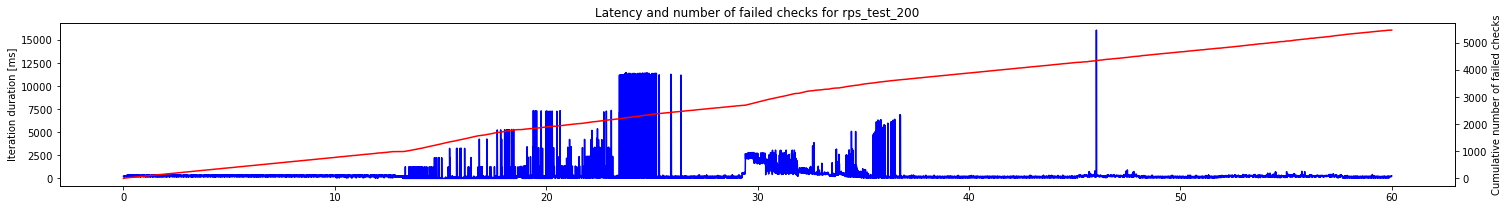

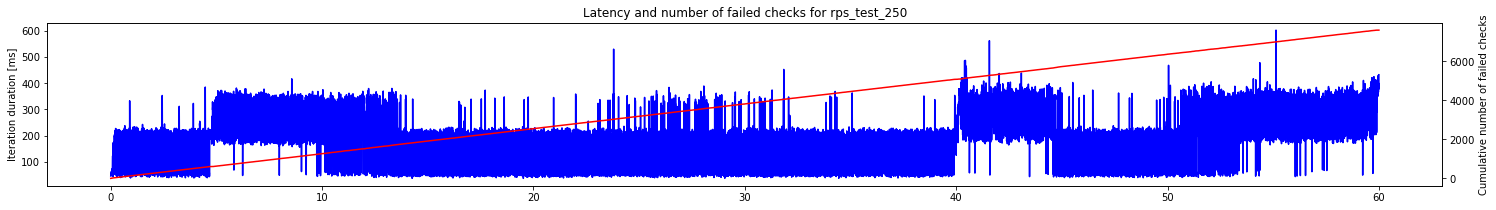

In [68]:
single_df = process_data("result-single-instance.json")
duration_vs_success(single_df, 60)

## Multi instance basic load analysis (`concurrency = 10`, `max-size = 5`)

The purpose of these tests was to roughly determine how much load 5 instances can handle at concurrency of 10. Given the highest RPS we have a full success rate for, we will then test the scaling response speed by ramping from 0 directly to that target RPS in the next section.

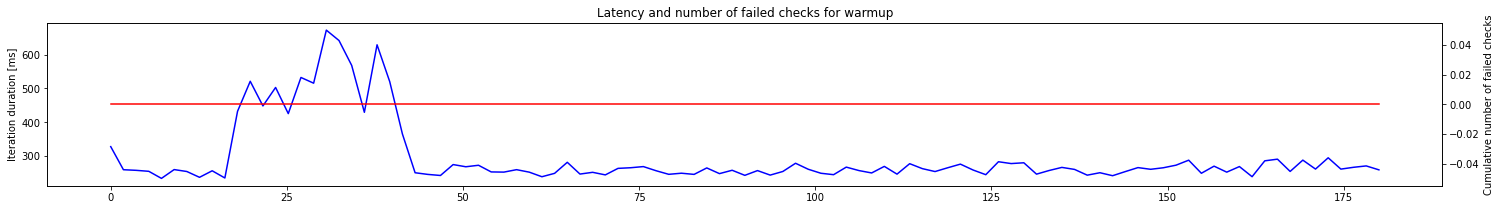

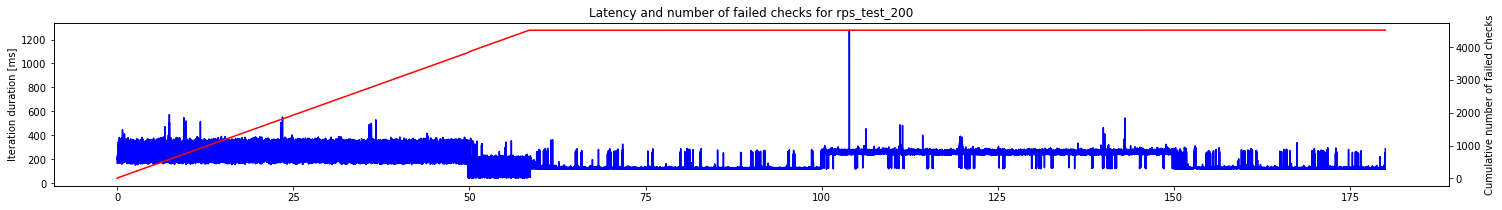

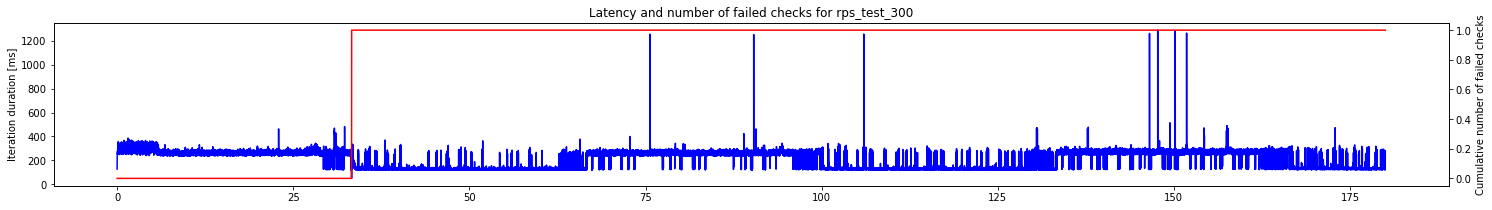

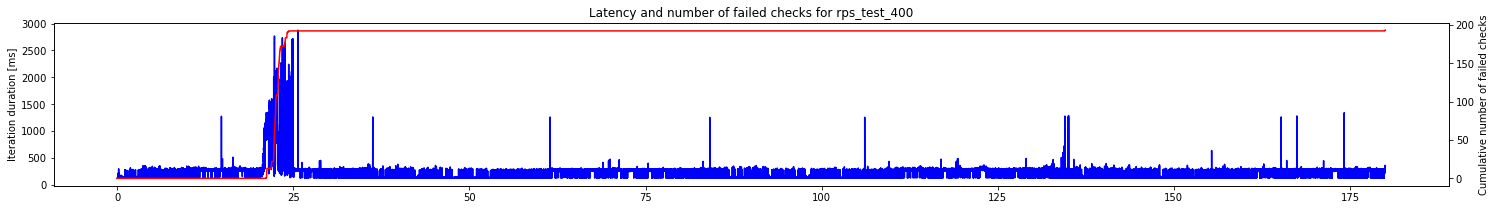

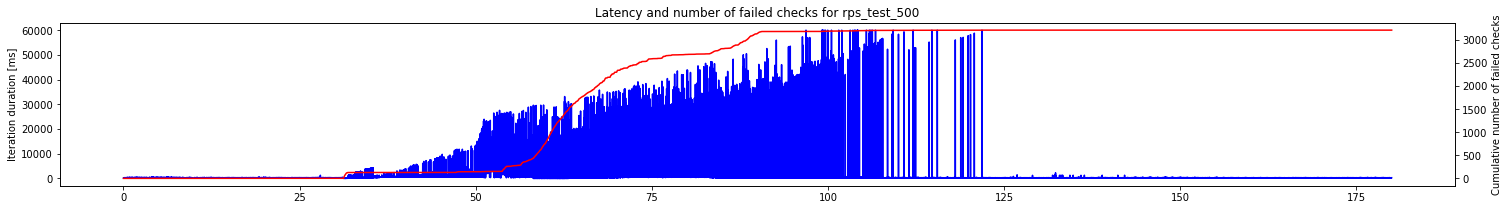

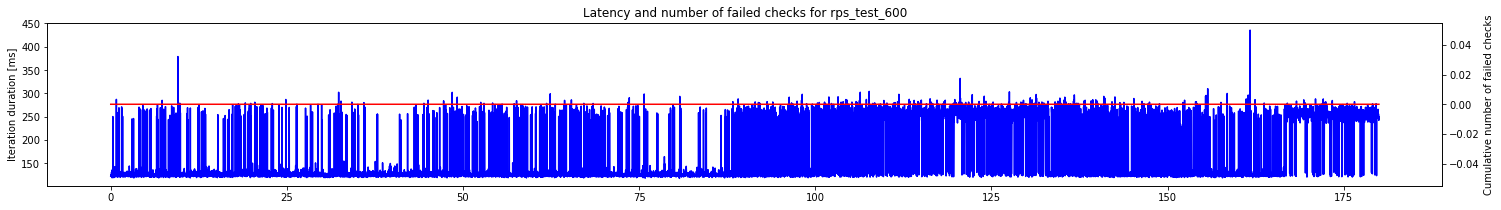

In [12]:
multi_df = process_data("result-multi-instance-200-600.json")
duration_vs_success(multi_df, 180)

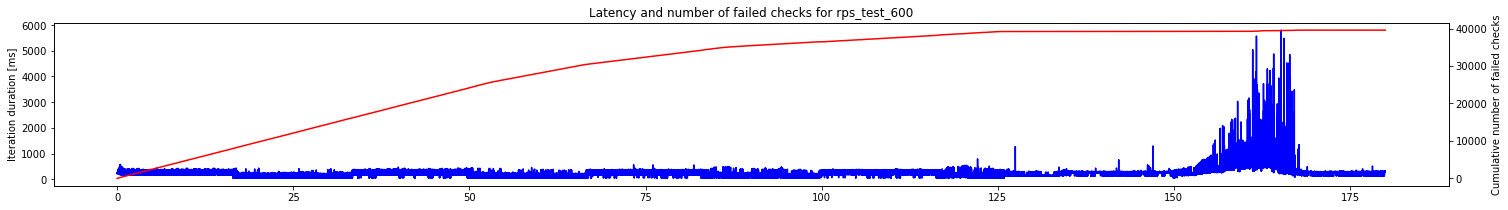

In [11]:
multi_df = process_data("600rps.json")
duration_vs_success(multi_df, 180)

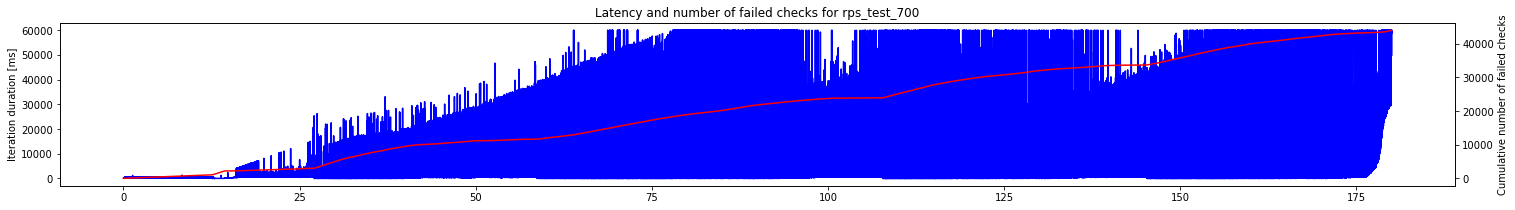

In [10]:
multi_df = process_data("700rps.json")
duration_vs_success(multi_df, 180)

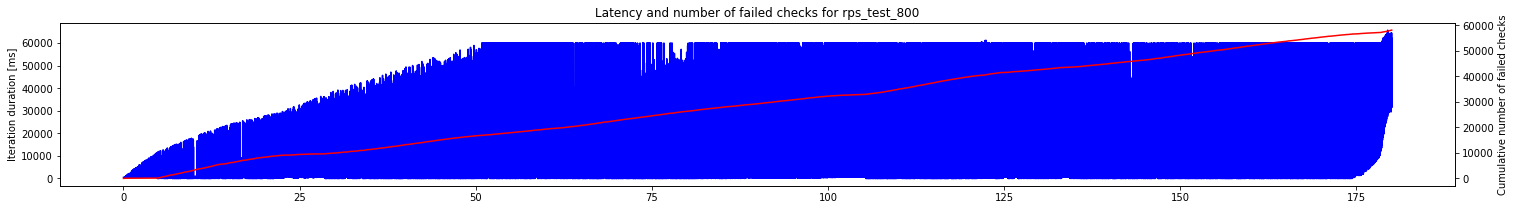

In [9]:
multi_df = process_data("800rps.json")
duration_vs_success(multi_df, 180)

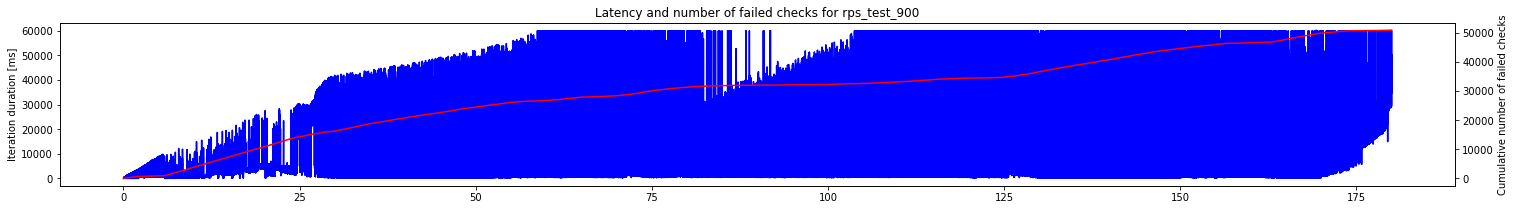

In [8]:
multi_df = process_data("900rps.json")
duration_vs_success(multi_df, 180)

## Scaling response speed at 600RPS

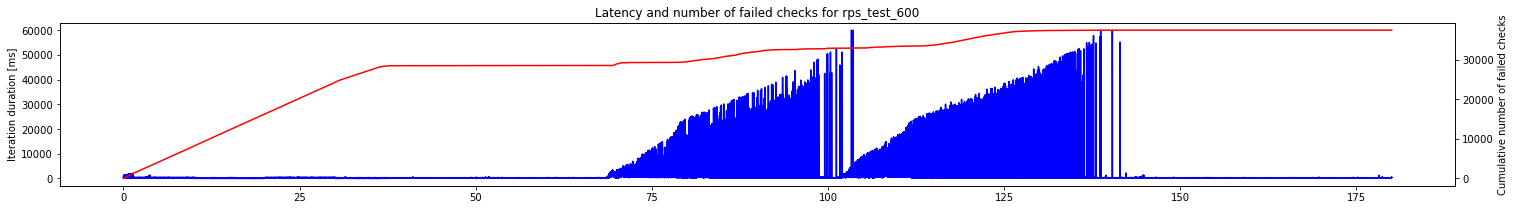

In [13]:
multi_df = process_data("result-600rps-first.json")
duration_vs_success(multi_df, 180)

This load requires all 5 instances, so at the start of the test we see failures starting to pile up quickly when an inactive single instance cannot handle the load. According to CloudWatch, we scale from 0 to 5 within the timespan of 1 minute (the most granular level of data available from AWS). From the graph below we start returning stable responses at approx 45 seconds. 

At that point things seemed to be fine, but confusingly about 1 minute in, the performance degrades with increased latency and several failures. It comes down and stabilises, but then degrades again at ~100 second mark.

As a result I decided to run the test again as this may have been caused by other activity on my computer at runtime.

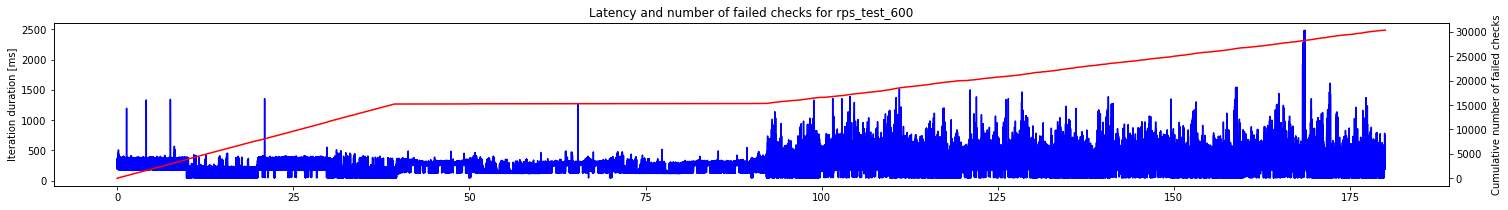

In [15]:
multi_df = process_data("result-600rps-second.json")
duration_vs_success(multi_df, 180)

The second run tells a similar story - we scale to 5 containers and stabilise responses at approx 40-45 seconds, but again see degradation at approx. 100 seconds.